<a href="https://colab.research.google.com/github/ccg-esb-lab/MDR_IS_Model/blob/main/MonodGillespieIS_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Effects of Network Connectivity on Plasmid Transmission

This notebook explores how altering the connectivity of the conjugation network affects plasmid
prevalence and the accumulation of SNP and IS mutations. Network structure is modified
by randomly removing donor–recipient links from an initially complete graph.


## Simulation parameters

In [1]:
# Core model parameters
eps = 1e-9                   # Conjugation rate
initial_resource = 1.0       # Initial resource concentration
simulation_time = 24.0       # Length of one growth cycle (h)
B0 = 1e8                     # Initial total population size
num_days = 60                # Number of serial-transfer cycles
dilution_factor = 0.1        # Fraction transferred at each dilution

# Mutation / transposition grid
num_mutationsSNP = 3         # Number of SNP mutation levels
num_mutationsIS = 3          # Number of IS transposition levels

# Replicates
num_reps = 3
days = range(num_days + 1)

# Strain identifiers and colors
strainIDs = ["K253", "K168", "K037", "K241", "K209"]
species_colors = ["orange", "blue", "purple", "green", "yellow"]
strain_color_map = {s: species_colors[i] for i, s in enumerate(strainIDs)}


In [2]:
import os
import sys
import glob
import pickle
import random
import itertools
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Wedge
import networkx as nx
from scipy.optimize import curve_fit, minimize
from scipy.stats import entropy
from sklearn.metrics import r2_score
from pprint import pprint
import importlib.util

## Clone GitHub repository

In [3]:

repo_url  = "https://github.com/ccg-esb-lab/MDR_IS_Model.git"
repo_name = "MDR_IS_Model"

if not Path(repo_name).exists():
  !git clone {repo_url}

REPO_ROOT = Path(repo_name).resolve()

In [5]:
# Repository paths
pathCODE    = REPO_ROOT / "code"
pathPARAMS  = REPO_ROOT / "data"
pathFIGURES = REPO_ROOT / "figures"
pathSIM     = REPO_ROOT / f"runs_eps{eps}"

print("pathCODE:", pathCODE)
print("pathPARAMS:", pathPARAMS)
print("pathFIGURES:", pathFIGURES)
print("pathSIM:", pathSIM)

# Ensure output directories exist
pathFIGURES.mkdir(parents=True, exist_ok=True)
pathSIM.mkdir(parents=True, exist_ok=True)

# Import model module
import sys
sys.path.append(str(pathCODE))
import MonodGillespieIS_multispecies as mg

print("Module loaded successfully.")


pathCODE: /content/drive/MyDrive/SYNC_Projects/IS/code
pathPARAMS: /content/drive/MyDrive/SYNC_Projects/IS/data
pathFIGURES: /content/drive/MyDrive/SYNC_Projects/IS/figures
pathSIM: /content/drive/MyDrive/SYNC_Projects/IS/runs_eps1e-09
Module loaded successfully.


### Load parameters from file

In [6]:

num_species = len(strainIDs)  # Number of species (e.g., "E" and "K")
strains_species = mg.load_strain_parameters(strainIDs, pathPARAMS)

#mg.plot_parameter_scatter(strainIDs, strains_species, strain_color_map)

Plasmid-free parameters for strain K253 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K253_0.pkl

Plasmid-bearing parameters for strain K253 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K253_p.pkl

Plasmid-free parameters for strain K168 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K168_0.pkl

Plasmid-bearing parameters for strain K168 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K168_p.pkl

Plasmid-free parameters for strain K037 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K037_0.pkl

Plasmid-bearing parameters for strain K037 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K037_p.pkl

Plasmid-free parameters for strain K241 loaded successfully from:
/content/drive/MyDrive/SYNC_Projects/IS/data/params_K241_0.pkl

Plasmid-bearing parameters for strain K241 loaded successfully from:
/content/dri

### Define transmission network

In [7]:
# Plasmid transfer matrix (fully connected, uniform rate = eps)
plasmid_matrix = np.full((len(strainIDs), len(strainIDs)), eps)

df_plasmid = pd.DataFrame(plasmid_matrix, index=strainIDs, columns=strainIDs)
print(df_plasmid)


              K253          K168          K037          K241          K209
K253  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09
K168  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09
K037  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09
K241  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09
K209  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09


## Run single-day clonal experiments



A=0.0
	Simulating K253 in isolation
	Simulating K168 in isolation
	Simulating K037 in isolation
	Simulating K241 in isolation
	Simulating K209 in isolation


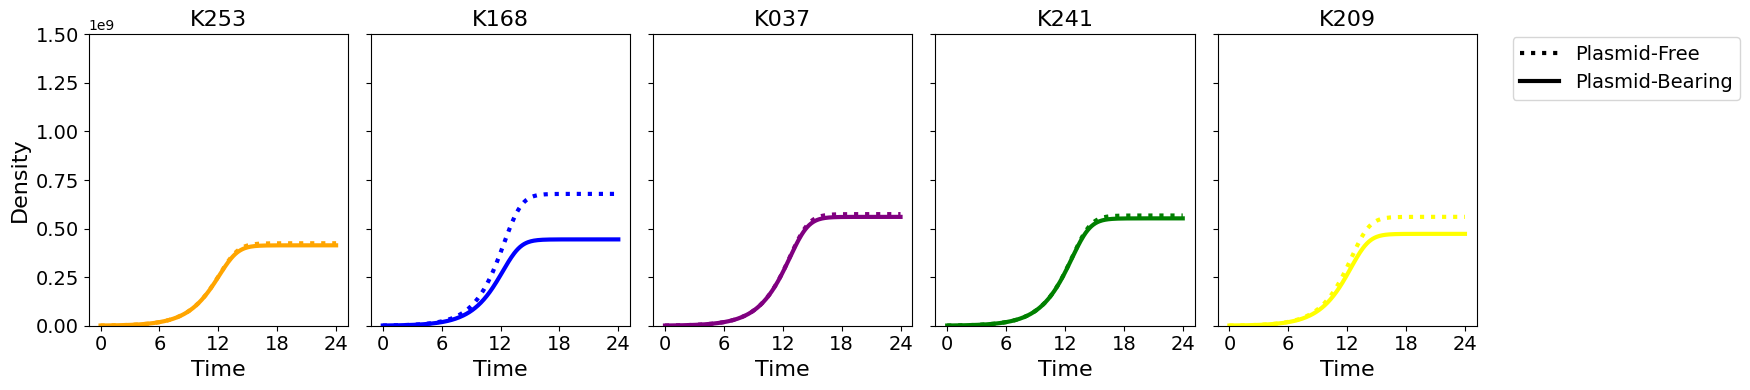

In [8]:
# No-transfer network (all zeros)
plasmid_matrix0 = np.zeros((len(strainIDs), len(strainIDs)))

antibiotic_concentration = 0.0
expe_label = f"A={antibiotic_concentration}"
print(expe_label)

all_time_series_results = []

# Single-strain simulations
for strain in strainIDs:
    print(f"\tSimulating {strain} in isolation")

    # Initial populations: only the focal strain starts at 1e6 (both states)
    initial_values_by_strain = {
        s: {"0": 0, "p": 0} for s in strainIDs
    }
    initial_values_by_strain[strain]["0"] = 1e6
    initial_values_by_strain[strain]["p"] = 1e6

    populations_0, populations_p = mg.initialize_populations(
        num_species=num_species,
        num_mutationsSNP=num_mutationsSNP,
        num_mutationsIS=num_mutationsIS,
        strainIDs=strainIDs,
        initial_values_by_strain=initial_values_by_strain
    )

    this_results = mg.runSimulationIS_multi_species(
        strains=strains_species,
        plasmid_matrix=plasmid_matrix0,
        initial_populations_0=populations_0,
        initial_populations_p=populations_p,
        num_days=1,
        antibiotic_concentration=antibiotic_concentration,
        initial_resource=initial_resource,
        simulation_time=simulation_time
    )

    all_time_series_results.append({
        "strain": strain,
        "results": this_results
    })

# Plot time-dependent densities
mg.plotTimeDependentStrainDensities(
    results_list=all_time_series_results,
    num_species=num_species,
    species_colors=species_colors,
    species_labels=strainIDs,
    simulation_time=simulation_time,
    title="",
    outPath=""
)


A=0.2
	Simulating K253 in isolation
	Simulating K168 in isolation
	Simulating K037 in isolation
	Simulating K241 in isolation
	Simulating K209 in isolation


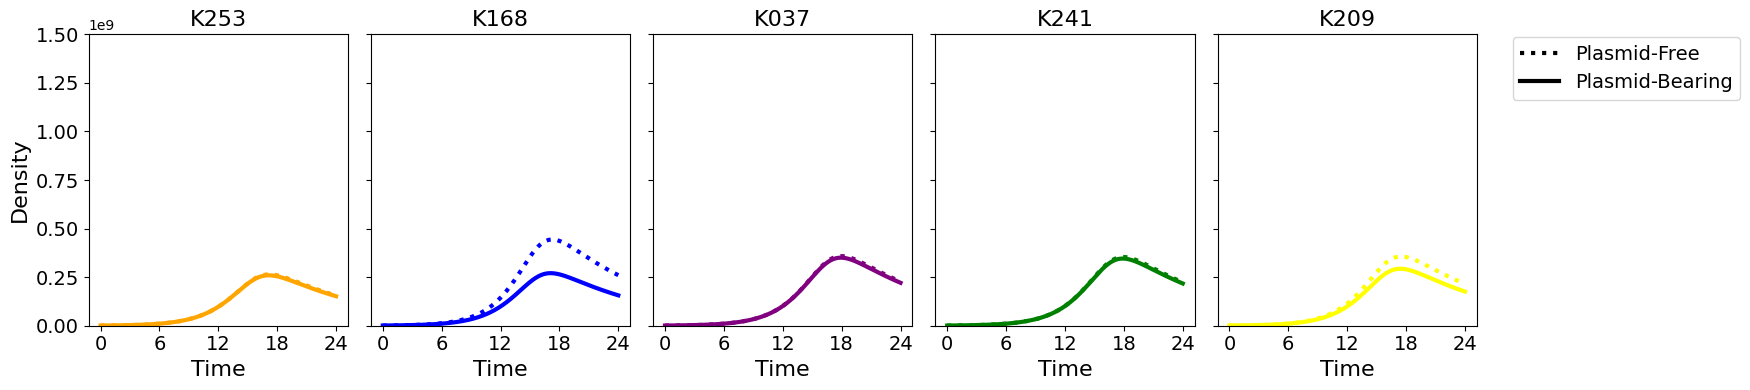

In [9]:
antibiotic_concentration = 0.2
expe_label = f"A={antibiotic_concentration}"
print(expe_label)

all_time_series_results = []

# Single-strain simulations
for strain in strainIDs:
    print(f"\tSimulating {strain} in isolation")

    # Initial populations: only the focal strain starts at 1e6 (both states)
    initial_values_by_strain = {
        s: {"0": 0, "p": 0} for s in strainIDs
    }
    initial_values_by_strain[strain]["0"] = 1e6
    initial_values_by_strain[strain]["p"] = 1e6

    populations_0, populations_p = mg.initialize_populations(
        num_species=num_species,
        num_mutationsSNP=num_mutationsSNP,
        num_mutationsIS=num_mutationsIS,
        strainIDs=strainIDs,
        initial_values_by_strain=initial_values_by_strain
    )

    this_results = mg.runSimulationIS_multi_species(
        strains=strains_species,
        plasmid_matrix=plasmid_matrix0,
        initial_populations_0=populations_0,
        initial_populations_p=populations_p,
        num_days=1,
        antibiotic_concentration=antibiotic_concentration,
        initial_resource=initial_resource,
        simulation_time=simulation_time
    )

    all_time_series_results.append({
        "strain": strain,
        "results": this_results
    })

# Plot time-dependent densities
mg.plotTimeDependentStrainDensities(
    results_list=all_time_series_results,
    num_species=num_species,
    species_colors=species_colors,
    species_labels=strainIDs,
    simulation_time=simulation_time,
    title="",
    outPath=""
)


## Run single-day clonal dose-responses


In [10]:
# Antibiotic concentrations to explore
antibiotic_concentrations = np.logspace(-3, 1, num=10)

# Container for final populations across all strains
dose_response_results = {strain: [] for strain in strainIDs}

for strain in strainIDs:
    print(f"\nDose–response for {strain}")

    for conc in antibiotic_concentrations:
        print(f"  concentration = {conc}")

        # --- Plasmid-free inoculum ---
        init_vals = {s: {"0": 0, "p": 0} for s in strainIDs}
        init_vals[strain]["0"] = B0
        pop0, popp = mg.initialize_populations(
            num_species=num_species,
            num_mutationsSNP=num_mutationsSNP,
            num_mutationsIS=num_mutationsIS,
            strainIDs=strainIDs,
            initial_values_by_strain=init_vals
        )
        results_free = mg.runSimulationIS_multi_species(
            strains=strains_species,
            plasmid_matrix=plasmid_matrix0,
            initial_populations_0=pop0,
            initial_populations_p=popp,
            num_days=1,
            antibiotic_concentration=conc,
            initial_resource=initial_resource,
            simulation_time=simulation_time
        )
        fp0 = np.sum(results_free[0]["final_populations_0"])

        # --- Plasmid-bearing inoculum ---
        init_vals = {s: {"0": 0, "p": 0} for s in strainIDs}
        init_vals[strain]["p"] = B0
        pop0, popp = mg.initialize_populations(
            num_species=num_species,
            num_mutationsSNP=num_mutationsSNP,
            num_mutationsIS=num_mutationsIS,
            strainIDs=strainIDs,
            initial_values_by_strain=init_vals
        )
        results_plasmid = mg.runSimulationIS_multi_species(
            strains=strains_species,
            plasmid_matrix=plasmid_matrix0,
            initial_populations_0=pop0,
            initial_populations_p=popp,
            num_days=1,
            antibiotic_concentration=conc,
            initial_resource=initial_resource,
            simulation_time=simulation_time
        )
        fpp = np.sum(results_plasmid[0]["final_populations_p"])

        # Store outcome
        dose_response_results[strain].append({
            "antibiotic_concentration": conc,
            "final_population_0": fp0,
            "final_population_p": fpp
        })



Dose–response for K253
  concentration = 0.001
  concentration = 0.0027825594022071257
  concentration = 0.007742636826811269
  concentration = 0.021544346900318832
  concentration = 0.05994842503189409
  concentration = 0.1668100537200059
  concentration = 0.46415888336127775
  concentration = 1.2915496650148828
  concentration = 3.593813663804626
All populations went to zero on day 1. Stopping simulation.
  concentration = 10.0
All populations went to zero on day 1. Stopping simulation.
All populations went to zero on day 1. Stopping simulation.

Dose–response for K168
  concentration = 0.001
  concentration = 0.0027825594022071257
  concentration = 0.007742636826811269
  concentration = 0.021544346900318832
  concentration = 0.05994842503189409
  concentration = 0.1668100537200059
  concentration = 0.46415888336127775
  concentration = 1.2915496650148828
  concentration = 3.593813663804626
All populations went to zero on day 1. Stopping simulation.
All populations went to zero on d

Exporting /content/drive/MyDrive/SYNC_Projects/IS/figuresdoseResponse.pdf


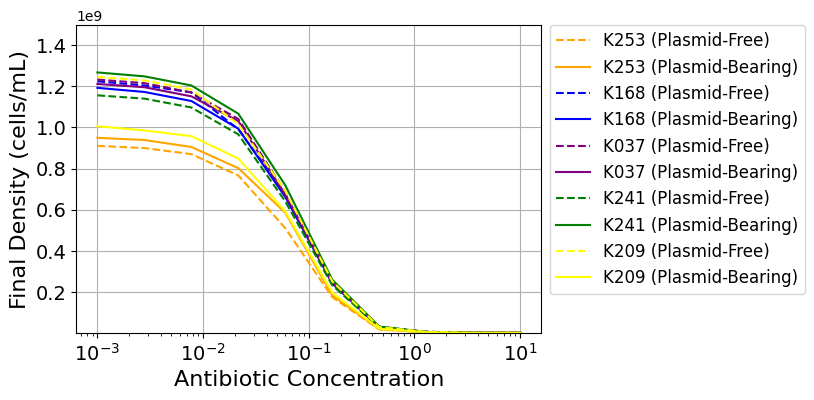

In [11]:

# Plotting function
mg.plot_dose_response_curve(dose_response_results, strainIDs, species_colors, outPath=pathFIGURES)


## Run experiments for different transmission matrices

### Removing rows/columns

In [12]:
antibiotic_concentration = 0.2
expe_label = f"A={antibiotic_concentration}"

# Fully connected plasmid-transfer network
plasmid_matrix_complete = np.full((len(strainIDs), len(strainIDs)), eps)


def zero_out_strains(matrix, strainIDs, strains_to_zero):
    """ Zero out all incoming and outgoing transfer for selected strains. """
    new_matrix = matrix.copy()
    idx = [i for i, s in enumerate(strainIDs) if s in strains_to_zero]
    new_matrix[idx, :] = 0
    new_matrix[:, idx] = 0
    return new_matrix


# NOTE: this range is empty on purpose (debug switch)
for num_removals in []:
    for strains_to_zero in itertools.combinations(strainIDs, num_removals):

        new_matrix = zero_out_strains(plasmid_matrix_complete, strainIDs, strains_to_zero)
        df_plasmid = pd.DataFrame(new_matrix, index=strainIDs, columns=strainIDs)
        print(f"\n=== {num_removals} removals {strains_to_zero} ===")
        print(df_plasmid)

        # Initial conditions: K241 carries a small plasmid-bearing seed
        initial_values_by_strain = {
            "K253": {"0": 1e6, "p": 0},
            "K168": {"0": 1e6, "p": 0},
            "K037": {"0": 1e6, "p": 0},
            "K241": {"0": 1e6, "p": 100},
            "K209": {"0": 1e6, "p": 0},
        }

        populations_0, populations_p = mg.initialize_populations(
            num_species=num_species,
            num_mutationsSNP=num_mutationsSNP,
            num_mutationsIS=num_mutationsIS,
            strainIDs=strainIDs,
            initial_values_by_strain=initial_values_by_strain
        )

        # Run stochastic replicates
        results = mg.runManySimulations(
            plasmid_matrix=new_matrix,
            num_reps=1,
            runSimulationIS_multi_species=mg.runSimulationIS_multi_species,
            strains=strains_species,
            initial_populations_0=populations_0,
            initial_populations_p=populations_p,
            num_days=num_days,
            antibiotic_concentration=antibiotic_concentration,
            initial_resource=initial_resource,
            simulation_time=simulation_time,
            dilution_factor=dilution_factor
        )

        # Compute summary statistics
        diversity_metrics = mg.computeStrainDiversity(results)
        stats = mg.computeMutationAndISTranspositionStatistics(
            results, num_mutationsSNP, num_mutationsIS, num_species
        )
        cum_free, cum_bearing = mg.computeCumulativeStrainDensities(
            results, num_species, num_days
        )
        plasmid_frac = mg.computePlasmidFraction(results)

        # Print summaries
        mg.printCumulativeStrainDensities(cum_free, cum_bearing, num_species, strainIDs)
        mg.printPlasmidFraction(plasmid_frac)
        mg.printStrainDiversity(diversity_metrics)
        mg.printMutationAndISTranspositionStatistics(stats)

        # Plots
        mg.plotResults(
            new_matrix,
            populations_0,
            populations_p,
            results,
            num_mutationsSNP,
            num_mutationsIS,
            num_days,
            num_species,
            species_colors,
            strainIDs,
            pathFIGURES,
            expe_path="",
            antibiotic_concentration=antibiotic_concentration
        )

        # Save results
        mg.save_simulation_results(
            new_matrix,
            num_reps=1,
            initial_values_by_strain=initial_values_by_strain,
            num_mutationsSNP=num_mutationsSNP,
            num_mutationsIS=num_mutationsIS,
            strainIDs=strainIDs,
            results=results,
            diversity_metrics=diversity_metrics,
            stats=stats,
            cumulative_densities_free=cum_free,
            cumulative_densities_bearing=cum_bearing,
            plasmid_fraction_stats=plasmid_frac,
            save_path=pathSIM
        )

        print("\n" + "=" * 45 + "\n")


## Stochastic networks


In [13]:
def randomly_remove_transmission(plasmid_matrix, num_removals):
    """
    Remove a given number of random nonzero entries from a plasmid transfer matrix.
    """
    updated = plasmid_matrix.copy()
    indices = np.argwhere(updated > 0)

    if len(indices) == 0:
        return updated

    num_removals = min(num_removals, len(indices))
    np.random.shuffle(indices)

    for i in range(num_removals):
        r, c = indices[i]
        updated[r, c] = 0

    return updated


In [14]:
antibiotic_concentration = 0.2
expe_label = f"A={antibiotic_concentration}"

# Fully connected transfer matrix
plasmid_matrix_complete = np.full((len(strainIDs), len(strainIDs)), eps)

total_edges = len(strainIDs) * len(strainIDs)
num_reps = 3
num_expe = 0   # set >0 to run experiments


for _ in range(num_expe):

    # Randomly remove between 0 and all possible edges
    num_removals = np.random.randint(0, total_edges + 1)
    new_matrix = randomly_remove_transmission(plasmid_matrix_complete, num_removals)

    print(f"\n=== Removed {num_removals} edges ===")
    print(pd.DataFrame(new_matrix, index=strainIDs, columns=strainIDs))

    # Random single-strain plasmid invasion
    initial_values_by_strain = {
        s: {"0": 1e6, "p": 0} for s in strainIDs
    }
    invader = random.choice(strainIDs)
    initial_values_by_strain[invader]["p"] = 100

    print("Initial densities:")
    for s, vals in initial_values_by_strain.items():
        print(f"\t{s}: {vals}")

    populations_0, populations_p = mg.initialize_populations(
        num_species=num_species,
        num_mutationsSNP=num_mutationsSNP,
        num_mutationsIS=num_mutationsIS,
        strainIDs=strainIDs,
        initial_values_by_strain=initial_values_by_strain
    )

    # Replicate simulations
    results = mg.runManySimulations(
        plasmid_matrix=new_matrix,
        num_reps=num_reps,
        runSimulationIS_multi_species=mg.runSimulationIS_multi_species,
        strains=strains_species,
        initial_populations_0=populations_0,
        initial_populations_p=populations_p,
        num_days=num_days,
        antibiotic_concentration=antibiotic_concentration,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        dilution_factor=dilution_factor
    )

    # Summary metrics
    diversity = mg.computeStrainDiversity(results)
    stats = mg.computeMutationAndISTranspositionStatistics(
        results, num_mutationsSNP, num_mutationsIS, num_species
    )
    cum0, cump = mg.computeCumulativeStrainDensities(results, num_species, num_days)
    plasmid_frac = mg.computePlasmidFraction(results)

    mg.printCumulativeStrainDensities(cum0, cump, num_species, strainIDs)
    mg.printPlasmidFraction(plasmid_frac)
    mg.printStrainDiversity(diversity)
    mg.printMutationAndISTranspositionStatistics(stats)

    # Save output
    mg.save_simulation_results(
        new_matrix,
        num_reps,
        initial_values_by_strain,
        num_mutationsSNP,
        num_mutationsIS,
        strainIDs,
        results,
        diversity,
        stats,
        cum0,
        cump,
        plasmid_frac,
        save_path=pathSIM
    )

    print("\n" + "=" * 45 + "\n")


# Load and plot simulation results

In [15]:
plasmid_fractions = []
num_zeros_in_matrix = []
SNP_Frequencies = []
IS_Frequencies = []
total_mutants = []
total_populations = []

network_densities = []
network_degrees = []
network_component_sizes = []
network_path_lengths = []
network_clustering_coefficients = []

# Retrieve all .pkl files in pathSIM
pkl_files = list(Path(pathSIM).glob("*.pkl"))

for file_path in pkl_files:

    # Load data for this simulation
    loaded_data = mg.load_simulation_results(file_path)

    # Network metrics
    plasmid_matrix = loaded_data["plasmid_matrix"]
    network_metrics = mg.compute_network_measures(plasmid_matrix)
    num_zeros = np.sum(plasmid_matrix == 0)
    num_zeros_in_matrix.append(num_zeros)

    network_densities.append(network_metrics["Density"])
    network_degrees.append(network_metrics["Mean Degree"])
    network_component_sizes.append(network_metrics["Giant Component Size"])
    network_path_lengths.append(network_metrics["Avg Path Length"])
    network_clustering_coefficients.append(network_metrics["Clustering Coefficient"])

    # Core results and statistics
    results = loaded_data["results"]
    num_mutationsSNP = loaded_data["num_mutationsSNP"]
    num_mutationsIS = loaded_data["num_mutationsIS"]
    strainIDs = loaded_data["strainIDs"]
    cumulative_densities_free = loaded_data["cumulative_densities_free"]
    cumulative_densities_bearing = loaded_data["cumulative_densities_bearing"]
    plasmid_fraction_stats = loaded_data["plasmid_fraction_stats"]
    diversity_metrics = loaded_data["diversity_metrics"]
    stats = loaded_data["mutation_statistics"]

    # Total mutant cells and total population
    total_mutant_cells = stats["Total_Mutant_Cells"]
    total_cells = stats["Total_Population"]
    total_mutants.append(total_mutant_cells)
    total_populations.append(total_cells)

    num_species = (
        loaded_data["num_species"]
        if "num_species" in loaded_data
        else len(loaded_data["strainIDs"])
    )

    plasmid_fraction = plasmid_fraction_stats["Plasmid Fraction"]
    plasmid_fractions.append(plasmid_fraction)

    SNP_Frequencies.append(stats["SNP_Cumulative_Frequency"])
    IS_Frequencies.append(stats["IS_Cumulative_Frequency"])

    expe_path = ""  # If empty, do not save figures
    if False:
        # if loaded_data['initial_values_by_strain']['K241']['p']>0:
        expe_path = os.path.join(
            pathFIGURES,
            mg.matrix_to_binary_filename(plasmid_matrix)
        )
        #print(expe_path)

        # mg.plotResults(plasmid_matrix, populations_0, populations_p, results,
        #               num_mutationsSNP, num_mutationsIS, num_days,
        #               num_species, species_colors, strainIDs,
        #               pathFIGURES, expe_path, antibiotic_concentration)

        mg.plot_HGT_network(
            plasmid_matrix,
            strainIDs,
            species_colors,
            outPath=expe_path,
            node_alpha=0.45
        )

        frequencies_free, frequencies_bearing = mg.calculateFrequenciesPerStrain(
            results=results,
            num_days=num_days,
            num_species=num_species,
            initial_populations_0=populations_0,
            initial_populations_p=populations_p
        )

        mg.plotStrainFrequenciesStackedArea(
            frequencies_free,
            frequencies_bearing,
            num_days,
            num_species,
            species_colors,
            strainIDs,
            "Density=%s" % network_metrics["Density"],
            expe_path
        )


print(f"Loaded {len(pkl_files)} .pkl files  {pathSIM}")

Loaded 1028 .pkl files  /content/drive/MyDrive/SYNC_Projects/IS/runs_eps1e-09


In [16]:
#print(total_mutants)
dominant_strains = np.argmax(total_mutants, axis=1)  # Get index of the strain with the highest mutation density

# Get indexes where dominant_strains == N
for N in range(num_species):
  indexesN = np.where(dominant_strains == N)[0]  # [0] extracts the array of indexes
  print(strainIDs[N],": ",
        len(indexesN),"/",len(total_mutants), "=",int(1000*len(indexesN)/len(total_mutants))/10,"%")



K253 :  64 / 1028 = 6.2 %
K168 :  406 / 1028 = 39.4 %
K037 :  4 / 1028 = 0.3 %
K241 :  13 / 1028 = 1.2 %
K209 :  541 / 1028 = 52.6 %


Exporting /content/drive/MyDrive/SYNC_Projects/IS/figuresplasmid_fraction_vs_network_density.pdf


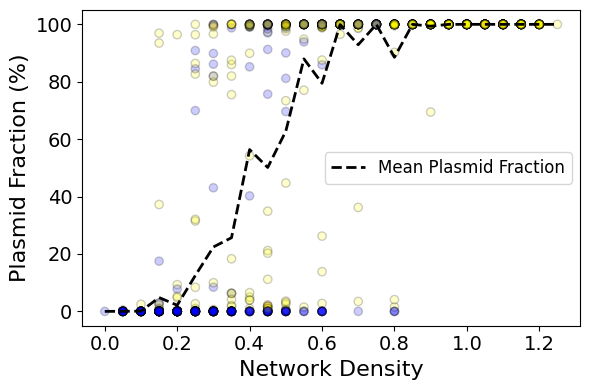

In [17]:
def plotPlasmidFractionVsX(x_values, plasmid_fractions, dominant_strains,
                           species_colors, x_label="X-Axis", outPath=""):
    """Scatter plot of plasmid fraction vs. a network metric, colored by dominant strain."""

    fig, ax = plt.subplots(figsize=(6, 4))

    # Jitter (currently zero, but kept for future use)
    jitter = 0.0 * (max(x_values) - min(x_values))
    jittered_x = x_values + np.random.uniform(-jitter, jitter, len(x_values))

    # Color by dominant strain
    colors = [species_colors[d] for d in dominant_strains]

    # Scatter points (% plasmid fraction)
    ax.scatter(
        jittered_x,
        100 * np.asarray(plasmid_fractions),
        color=colors,
        edgecolor="black",
        alpha=0.2
    )

    # Mean trend line
    unique_x = np.unique(x_values)
    mean_pf = [
        100 * np.mean([
            plasmid_fractions[i]
            for i in range(len(x_values)) if x_values[i] == x
        ])
        for x in unique_x
    ]
    ax.plot(unique_x, mean_pf, "k--", linewidth=2, label="Mean Plasmid Fraction")

    # Labels and axes
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel("Plasmid Fraction (%)", fontsize=16)
    ax.tick_params(axis="both", labelsize=14)
    ax.grid(False)
    ax.legend(fontsize=12)

    plt.tight_layout()

    # Save or show
    if outPath:
        filename = f"{outPath}plasmid_fraction_vs_{x_label.replace(' ', '_').lower()}.pdf"
        plt.savefig(filename, format="pdf")
        print(f"Exporting {filename}")

    plt.show()


# Determine dominant strain (unchanged logic)
dominant_strains = np.argmax(total_mutants, axis=1)

plotPlasmidFractionVsX(
    network_densities,
    plasmid_fractions,
    dominant_strains,
    species_colors,
    x_label="Network Density",
    outPath=pathFIGURES
)


In [18]:
def plotMutantsVsX_boxplot(x_values, total_mutants_per_case, total_population,
                           x_label="X-Axis", outPath=""):
    """Binned bar plot of mutation fraction (mutants per cell) vs. a network metric."""

    fig, ax = plt.subplots(figsize=(6, 4))

    # Total mutants and mutation fraction
    total_mutants = np.sum(total_mutants_per_case, axis=1)
    total_population = np.asarray(total_population)
    mutation_fraction = np.divide(
        total_mutants,
        total_population,
        out=np.zeros_like(total_mutants),
        where=total_population != 0
    )
    mutation_fraction = np.clip(mutation_fraction, 0, None)

    # Binning
    num_bins = 10
    bins = np.linspace(min(x_values), max(x_values), num_bins + 1)
    bin_indices = np.digitize(x_values, bins) - 1

    binned_data = {i: [] for i in range(num_bins)}
    for i, b in enumerate(bin_indices):
        if 0 <= b < num_bins:
            binned_data[b].append(mutation_fraction[i])

    # Use only bins with data
    boxplot_data = [binned_data[i] for i in range(num_bins) if binned_data[i]]
    bin_centers = [
        (bins[i] + bins[i + 1]) / 2
        for i in range(num_bins) if binned_data[i]
    ]

    mean_mut = [np.mean(vals) for vals in boxplot_data]
    std_err = [
        np.std(vals) / np.sqrt(len(vals)) if len(vals) > 1 else 0
        for vals in boxplot_data
    ]

    # Bar plot (mean ± SE)
    ax.bar(
        range(len(bin_centers)),
        mean_mut,
        yerr=std_err,
        capsize=0,
        color="#C3C3C3",
        edgecolor="#D6D6D6",
        width=0.7
    )

    # X-axis ticks
    ax.set_xticks(range(len(bin_centers)))
    ax.set_xticklabels(
        [f"{b:.1f}" if i % 2 == 0 else "" for i, b in enumerate(bin_centers)],
        fontsize=14
    )

    # Y-axis and labels
    ax.set_ylim([1.5, 2.25])
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel("Mutations per Cell", fontsize=16)
    ax.tick_params(axis="both", labelsize=14)
    ax.legend(["Mean ± SE"], fontsize=12, loc="upper left")
    ax.grid(False)

    plt.tight_layout()

    if outPath:
        filename = f"{outPath}mutation_fraction_vs_{x_label.replace(' ', '_').lower()}_boxplot.pdf"
        plt.savefig(filename, format="pdf", dpi=300)
        print(f"Exporting {filename}")


Exporting /content/drive/MyDrive/SYNC_Projects/IS/figuresmutation_frequencies_vs_network_density.pdf


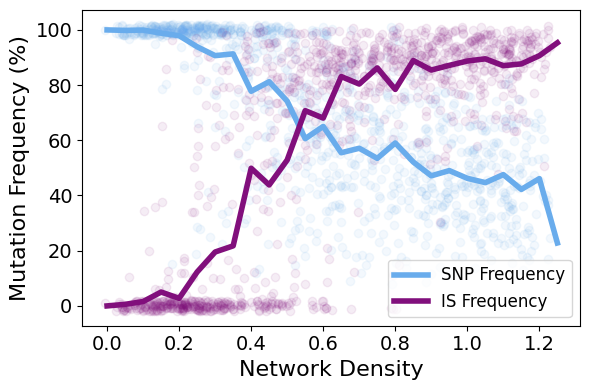

In [19]:
def plotMutationFrequenciesVsX(x_values, SNP_frequencies, IS_frequencies,
                               x_label="X-Axis", outPath=""):
    """Scatter and mean trend of SNP and IS frequencies vs. a network metric."""

    fig, ax = plt.subplots(figsize=(6, 4))

    # Jitter magnitude for scatter visualization
    jitter_x = 0.02 * (max(x_values) - min(x_values))
    jitter_y = 0.02 * (
        max(SNP_frequencies + IS_frequencies) -
        min(SNP_frequencies + IS_frequencies)
    )

    # Apply jitter
    jittered_x = x_values + np.random.uniform(-jitter_x, jitter_x, len(x_values))
    jittered_SNP = SNP_frequencies + np.random.uniform(-jitter_y, jitter_y, len(SNP_frequencies))
    jittered_IS = IS_frequencies + np.random.uniform(-jitter_y, jitter_y, len(IS_frequencies))

    # Scatter clouds
    ax.scatter(jittered_x, jittered_SNP,
               color="#69acecff", alpha=0.075, edgecolor="#69acecff")
    ax.scatter(jittered_x, jittered_IS,
               color="#810F7C", alpha=0.075, edgecolor="#810F7C")

    # Mean trends for each unique x
    unique_x = np.unique(x_values)
    mean_SNP = [
        np.mean([SNP_frequencies[i] for i in range(len(x_values)) if x_values[i] == x])
        for x in unique_x
    ]
    mean_IS = [
        np.mean([IS_frequencies[i] for i in range(len(x_values)) if x_values[i] == x])
        for x in unique_x
    ]

    ax.plot(unique_x, mean_SNP, "-", color="#69acecff", linewidth=4, label="SNP Frequency")
    ax.plot(unique_x, mean_IS, "-", color="#810F7C", linewidth=4, label="IS Frequency")

    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel("Mutation Frequency (%)", fontsize=16)
    ax.legend(fontsize=12, loc="lower right")
    ax.grid(False)
    ax.tick_params(axis="both", labelsize=14)

    plt.tight_layout()

    if outPath:
        filename = f"{outPath}mutation_frequencies_vs_{x_label.replace(' ', '_').lower()}.pdf"
        plt.savefig(filename, format="pdf", dpi=300)
        print(f"Exporting {filename}")
        plt.show()
    else:
        plt.show()


plotMutationFrequenciesVsX(
    network_densities, SNP_Frequencies, IS_Frequencies,
    x_label="Network Density", outPath=pathFIGURES
)
